In [1]:
from sklearn.ensemble import IsolationForest
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report, make_scorer
from sklearn.model_selection import cross_val_score, KFold

import shap
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv
import warnings

#load the preprocessed data
X_train = pd.read_csv("X_train_bin.csv")
X_test = pd.read_csv("X_test_bin.csv")
y_train = pd.read_csv("y_train_bin.csv").squeeze()
y_test = pd.read_csv("y_test_bin.csv").squeeze()

In [2]:
#get unique values and counts of each value
unique, counts = np.unique(y_train, return_counts=True)

#calculate percentage of attack in training set
cont_train = counts[1] / counts[0]

In [3]:
#define Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=700,
    contamination=0.4,
    max_samples=0.4,
    max_features=0.6,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

start_time = time.perf_counter()

#train the model on the training data
iso_forest.fit(X_train)
end_time = time.perf_counter()

training_time = end_time - start_time
print(f"\nTraining (convergence) time: {training_time} seconds")


Training (convergence) time: 140.03714030000265 seconds


In [4]:
#predict on the test data
y_pred_if = iso_forest.predict(X_test)

#fix the predictions to match the labels in the confusion matrix
y_pred = np.where(y_pred_if == -1, 1, 0)

In [5]:
#calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")

Accuracy: 0.5678294573643411
Recall: 0.4273609810099634
Precision: 0.24064735264735265
F1 Score: 0.30791019669398667


In [6]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69    242754
           1       0.24      0.43      0.31     70458

    accuracy                           0.57    313212
   macro avg       0.51      0.52      0.50    313212
weighted avg       0.66      0.57      0.60    313212



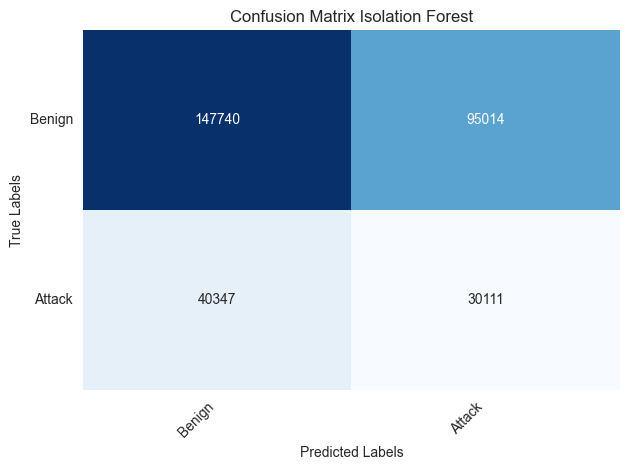

In [7]:
labels = [
    'Benign',
    'Attack'
]

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

#plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Isolation Forest')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
#export result before shap
#export iso_forest results
results_list = ["iso_forest", training_time, accuracy, recall, precision, f1, None, None, tn, fp, fn, tp]
file_path = 'results.csv'

# Check if the file exists to avoid duplicate headers
file_exists = os.path.isfile(file_path)

# Open and write to the file
with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data row
    writer.writerow(results_list)

In [9]:
np.random.seed(42)

#taking a random sample of the training data to boost function speed
sample_size = 10000
if len(X_train) > sample_size:
    #use the local rng for reproducible sampling
    X_test_sample = resample(X_test, n_samples=sample_size, random_state=42)
else:
    X_test_sample = X_test.copy()

# Ensure X_test_sample is a DataFrame
if not isinstance(X_test_sample, pd.DataFrame):
    X_test_sample = pd.DataFrame(X_test_sample)

explainer = shap.Explainer(iso_forest.decision_function, X_train)
shap_values = explainer(X_test_sample)

PermutationExplainer explainer: 10001it [5:10:51,  1.87s/it]                            


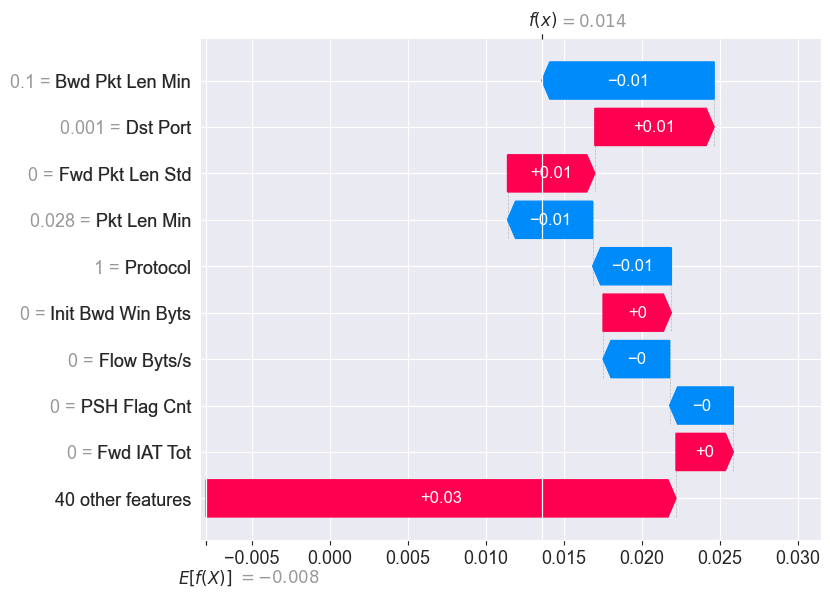

In [10]:
shap.plots.waterfall(shap_values[1])

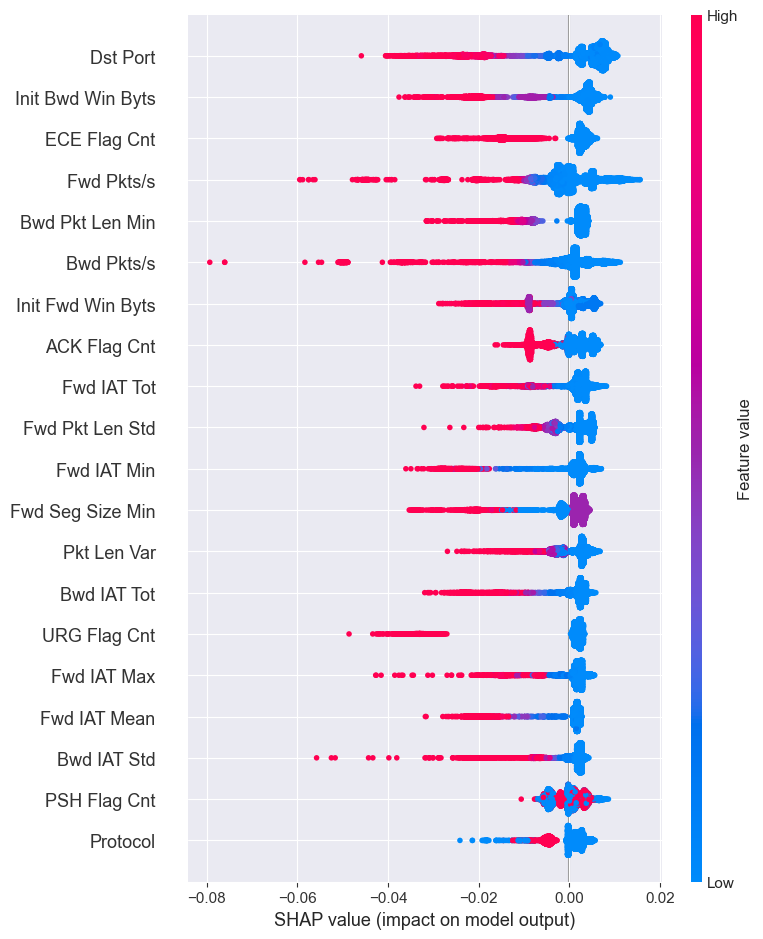

In [11]:
warnings.filterwarnings(
    "ignore",
    message=".*The NumPy global RNG was seeded by calling `np.random.seed`.*",
    category=FutureWarning,
)
shap.summary_plot(shap_values.values, X_test_sample)


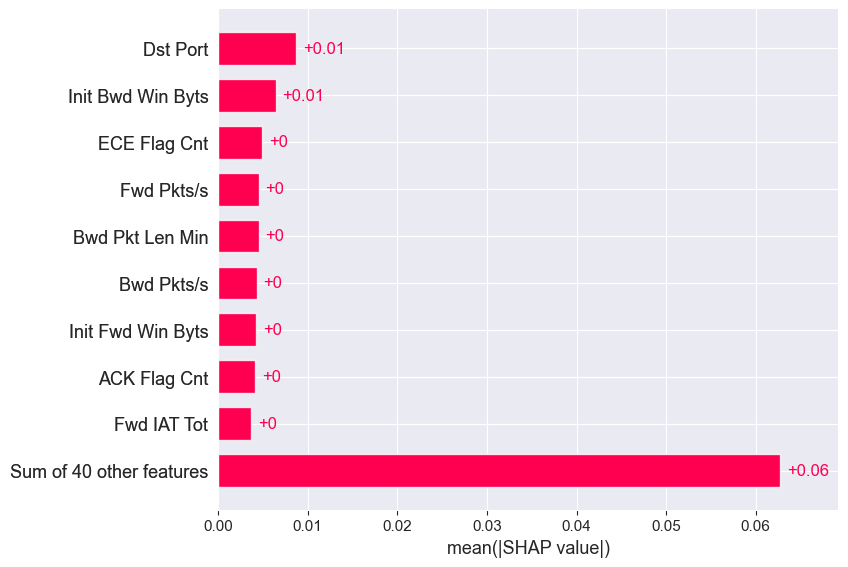

In [12]:
# Bar Plot: Mean absolute SHAP values for each feature
shap.plots.bar(shap_values)

In [13]:
# Calculating mean absolute SHAP values for feature importance
shap_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Mean_SHAP': np.abs(shap_values.values).mean(axis=0)
}).sort_values('Mean_SHAP', ascending=False)

print("\nMean Absolute SHAP Values (Feature Importance):")
print(shap_importance.to_string())

#set threshold for least significant features
threshold = 0.001
least_significant = shap_importance[shap_importance['Mean_SHAP'] < threshold]['Feature']

print(f"Dropping {len(least_significant)} least significant features:")


Mean Absolute SHAP Values (Feature Importance):
              Feature  Mean_SHAP
0            Dst Port   0.008735
41  Init Bwd Win Byts   0.006445
28       ECE Flag Cnt   0.004936
17         Fwd Pkts/s   0.004551
3     Bwd Pkt Len Min   0.004548
18         Bwd Pkts/s   0.004295
40  Init Fwd Win Byts   0.004241
25       ACK Flag Cnt   0.004134
5         Fwd IAT Tot   0.003727
2     Fwd Pkt Len Std   0.003716
8         Fwd IAT Min   0.003614
43   Fwd Seg Size Min   0.003591
21        Pkt Len Var   0.003465
9         Bwd IAT Tot   0.003455
26       URG Flag Cnt   0.003446
7         Fwd IAT Max   0.002986
6        Fwd IAT Mean   0.002847
11        Bwd IAT Std   0.002780
24       PSH Flag Cnt   0.002634
1            Protocol   0.002592
19        Pkt Len Min   0.002534
4         Flow Byts/s   0.002514
48           Idle Min   0.002472
12        Bwd IAT Max   0.002357
30   Bwd Seg Size Avg   0.002186
39   Subflow Bwd Byts   0.002032
47           Idle Max   0.001920
20        Pkt Len Std   0.0

In [14]:
#drop the least significant features from training and test sets
X_train_reduced = X_train.drop(columns=least_significant)
X_test_reduced = X_test.drop(columns=least_significant)

In [15]:
#define a new Isolation Forest model with reduced features
iso_forest_reduced = IsolationForest(
    n_estimators=700,
    contamination=0.4,
    max_samples=0.4,
    max_features=0.6,
    bootstrap=False,
    random_state=42,
    n_jobs=-1
)

start_time_red = time.perf_counter()

#train the model on the reduced training data
iso_forest_reduced.fit(X_train_reduced)

end_time_red = time.perf_counter()

training_time_red = end_time_red - start_time_red
print(f"\nTraining (convergence) time: {training_time_red} seconds")


Training (convergence) time: 131.65655469999183 seconds


In [16]:
#predict on the reduced test data
y_pred_if_reduced = iso_forest_reduced.predict(X_test_reduced)
y_pred_reduced = np.where(y_pred_if_reduced == -1, 1, 0)

In [17]:
#calculate evaluation metrics for reduced features
accuracy_reduced = accuracy_score(y_test, y_pred_reduced)
recall_reduced = recall_score(y_test, y_pred_reduced)
precision_reduced = precision_score(y_test, y_pred_reduced)
f1_reduced = f1_score(y_test, y_pred_reduced)

print(f"Accuracy: {accuracy_reduced}")
print(f"Recall: {recall_reduced}")
print(f"Precision: {precision_reduced}")
print(f"F1 Score: {f1_reduced}")

Accuracy: 0.5660670727813749
Recall: 0.42149933293593345
Precision: 0.23786753810542166
F1 Score: 0.3041129697044171


In [18]:
print("Classification Report:")
print(classification_report(y_test, y_pred_reduced))

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.61      0.68    242754
           1       0.24      0.42      0.30     70458

    accuracy                           0.57    313212
   macro avg       0.51      0.51      0.49    313212
weighted avg       0.66      0.57      0.60    313212



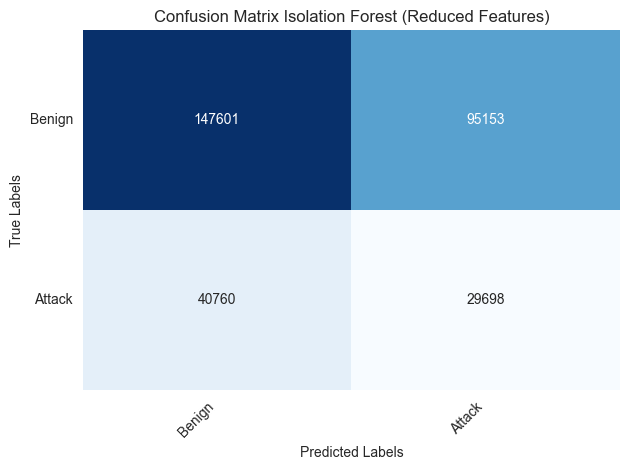

In [19]:
labels = [
    'Benign',
    'Attack'
]
cm_red = confusion_matrix(y_test, y_pred_reduced)
tn_red, fp_red, fn_red, tp_red = cm_red.ravel()
sns.heatmap(cm_red, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels,cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Isolation Forest (Reduced Features)')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [20]:
#export result after shap
#export iso_forest_reduced results
results_list = ["iso_forest_reduced", training_time_red, accuracy_reduced, recall_reduced, precision_reduced, f1_reduced, None, None, tn_red, fp_red, fn_red, tp_red]
file_path = 'results.csv'

# Check if the file exists to avoid duplicate headers
file_exists = os.path.isfile(file_path)

# Open and write to the file
with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data row
    writer.writerow(results_list)

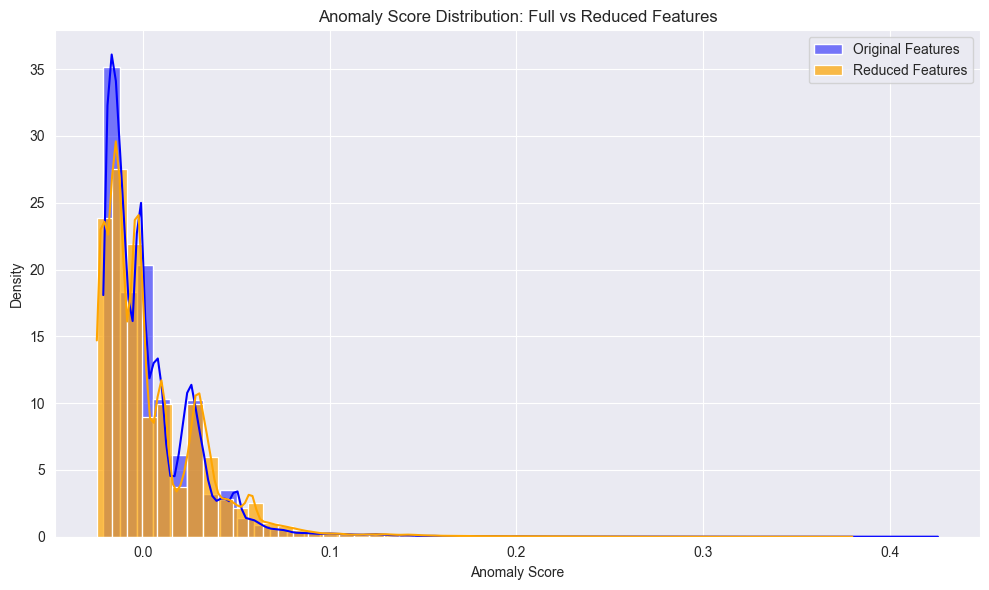

In [21]:
#calculate and plot anomaly scores for both models
scores_full = iso_forest.decision_function(X_test) * -1
scores_reduced = iso_forest_reduced.decision_function(X_test_reduced) * -1

plt.figure(figsize=(10, 6))

sns.histplot(scores_full, bins=50, kde=True, color='blue', label='Original Features', stat='density')
sns.histplot(scores_reduced, bins=50, kde=True, color='orange', label='Reduced Features', stat='density', alpha=0.7)

#customization of the plot
plt.title("Anomaly Score Distribution: Full vs Reduced Features")
plt.xlabel("Anomaly Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
k = 30
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [23]:
# Custom recall scorer for anomaly detection
def custom_recall(y_true, y_pred):
    # Map Isolation Forest predictions (-1/1) to match your labels (0/1)
    y_pred_mapped = np.where(y_pred == -1, 1, 0)  # -1 → 1 (attack), 1 → 0 (normal)
    return recall_score(y_true, y_pred_mapped, pos_label=1)  # Focus on attack recall

recall_scorer = make_scorer(custom_recall)

In [24]:
# Correct cross-validation setup
scores = cross_val_score(
    iso_forest,
    X_train,
    y_train,  # Will be used in evaluation despite Isolation Forest being unsupervised
    cv=kf,
    scoring=recall_scorer
)

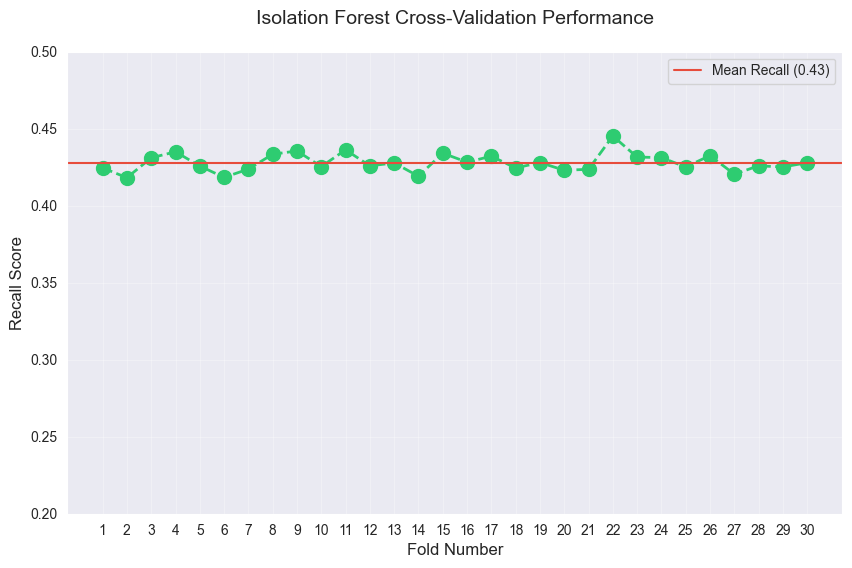

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores)+1), scores, marker='o', linestyle='--', color='#2ecc71', linewidth=2, markersize=10)
plt.axhline(y=np.mean(scores), color='#e74c3c', linestyle='-', label=f'Mean Recall ({np.mean(scores):.2f})')

# Formatting
plt.title('Isolation Forest Cross-Validation Performance', fontsize=14, pad=20)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Recall Score', fontsize=12)
plt.xticks(range(1, len(scores)+1))
plt.ylim(0.20, 0.50)  # Adjusted for your score range
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()

In [26]:
# Correct cross-validation setup
scores_reduced = cross_val_score(
    iso_forest_reduced,
    X_train_reduced,
    y_train,  # Will be used in evaluation despite Isolation Forest being unsupervised
    cv=kf,
    scoring=recall_scorer
)

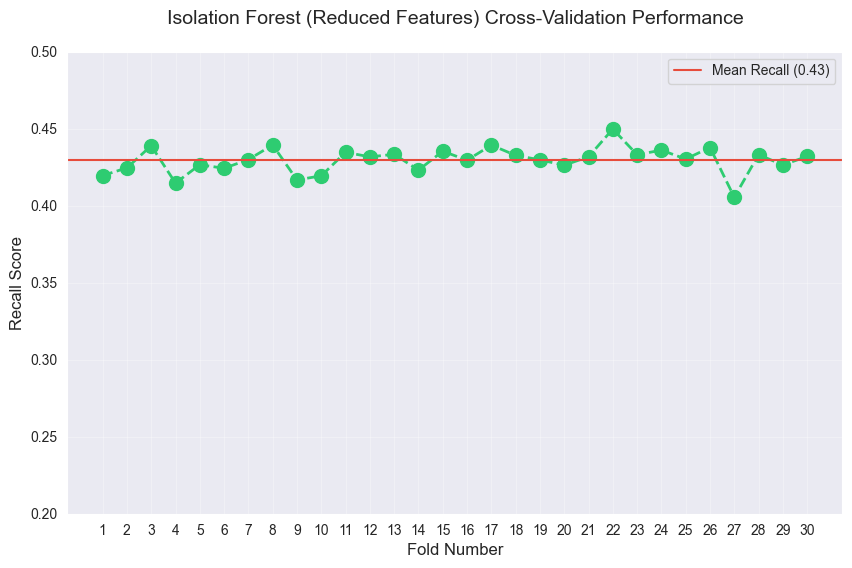

In [27]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(scores_reduced)+1), scores_reduced, marker='o', linestyle='--', color='#2ecc71', linewidth=2, markersize=10)
plt.axhline(y=np.mean(scores_reduced), color='#e74c3c', linestyle='-', label=f'Mean Recall ({np.mean(scores_reduced):.2f})')

# Formatting
plt.title('Isolation Forest (Reduced Features) Cross-Validation Performance', fontsize=14, pad=20)
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Recall Score', fontsize=12)
plt.xticks(range(1, len(scores_reduced)+1))
plt.ylim(0.20, 0.50)  # Adjusted for your score range
plt.grid(True, alpha=0.3)
plt.legend()

plt.show()
